In [12]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('test.csv')

# Lọc dữ liệu cho Publication_Day = Tuesday
tuesday_data = data[data['Publication_Day'] == 'Tuesday'].copy()

# Chọn cột Episode_Length_minutes làm chuỗi thời gian
time_series = tuesday_data['Episode_Length_minutes']

# Xử lý giá trị thiếu (thay bằng trung bình)
time_series = time_series.fillna(time_series.mean())

# Chuyển thành mảng numpy
time_series = time_series.values

# Kiểm tra dữ liệu
print("Số lượng điểm dữ liệu thứ Ba:", len(time_series))
print("Dữ liệu mẫu:", time_series[:5])

Số lượng điểm dữ liệu thứ Ba: 32777
Dữ liệu mẫu: [ 54.59       100.65        65.66562351  52.03        65.66562351]


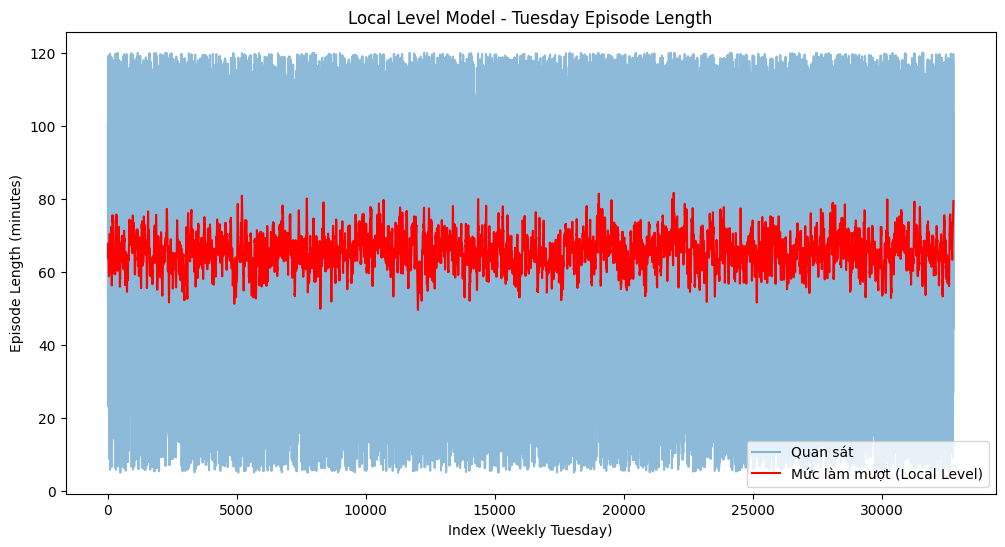

In [13]:
# Khởi tạo bộ lọc Kalman
kf1 = KalmanFilter(
    transition_matrices=[1],  # Ma trận chuyển trạng thái
    observation_matrices=[1],  # Ma trận quan sát
    transition_covariance=0.01,  # Nhiễu chuyển trạng thái
    observation_covariance=1.0,  # Nhiễu quan sát
    initial_state_mean=0,  # Giá trị ban đầu của mức
    initial_state_covariance=1  # Độ lệch ban đầu
)

# Làm mượt chuỗi thời gian
state_means1, state_covariances1 = kf1.smooth(time_series)

# Vẽ kết quả
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Quan sát', alpha=0.5)
plt.plot(state_means1, label='Mức làm mượt (Local Level)', color='red')
plt.legend()
plt.title('Local Level Model - Tuesday Episode Length')
plt.xlabel('Index (Weekly Tuesday)')
plt.ylabel('Episode Length (minutes)')
plt.show()

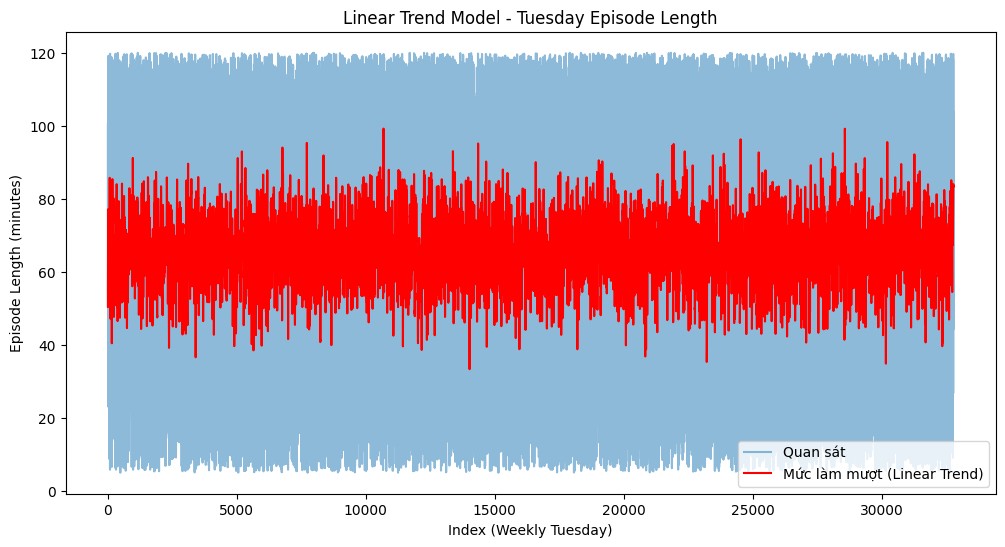

In [14]:
# Khởi tạo bộ lọc Kalman
kf2 = KalmanFilter(
    transition_matrices=[[1, 1], [0, 1]],  # Ma trận chuyển trạng thái (mức + xu hướng)
    observation_matrices=[[1, 0]],  # Quan sát chỉ mức
    transition_covariance=0.01 * np.eye(2),  # Nhiễu chuyển trạng thái
    observation_covariance=1.0,  # Nhiễu quan sát
    initial_state_mean=[0, 0],  # Giá trị ban đầu của mức và xu hướng
    initial_state_covariance=np.eye(2)  # Độ lệch ban đầu
)

# Làm mượt chuỗi thời gian
state_means2, state_covariances2 = kf2.smooth(time_series)

# Vẽ kết quả
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Quan sát', alpha=0.5)
plt.plot(state_means2[:, 0], label='Mức làm mượt (Linear Trend)', color='red')
plt.legend()
plt.title('Linear Trend Model - Tuesday Episode Length')
plt.xlabel('Index (Weekly Tuesday)')
plt.ylabel('Episode Length (minutes)')
plt.show()

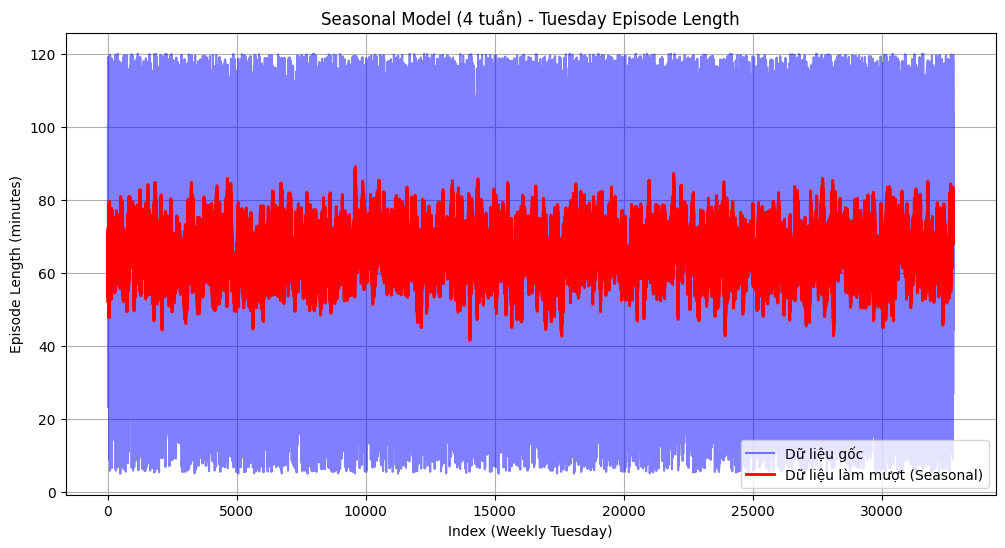

In [16]:
# Mô hình Seasonal (chu kỳ 4 tuần)
seasonal_period = 4
transition_matrix = np.zeros((seasonal_period, seasonal_period))
transition_matrix[:-1, 1:] = np.eye(seasonal_period - 1)
transition_matrix[-1, 0] = 1
kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=[[1] + [0] * (seasonal_period - 1)],
    transition_covariance=0.01 * np.eye(seasonal_period),
    observation_covariance=1.0,
    initial_state_mean=np.zeros(seasonal_period),
    initial_state_covariance=np.eye(seasonal_period)
)
state_means, _ = kf.smooth(time_series)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Dữ liệu gốc', alpha=0.5, color='blue')
plt.plot(state_means[:, 0], label='Dữ liệu làm mượt (Seasonal)', color='red', linewidth=2)
plt.legend()
plt.title('Seasonal Model (4 tuần) - Tuesday Episode Length')
plt.xlabel('Index (Weekly Tuesday)')
plt.ylabel('Episode Length (minutes)')
plt.grid(True)
plt.show()